# Synthetic Example of DTW And Its Approximations

Below, we show basic usage of the library by aligning two different parameterizations of a Figure 8 using the core linear memory, divide and conquer technique (linmdtw), as well as two approximate techniques (fastdtw and mrmsdtw).  First, we setup the a Lissajous curve and its re-parameterization, and we plot them colored by their sample index

Text(0.5, 1.0, 'Warped Time Series $Y(t) = X(s(t))$')

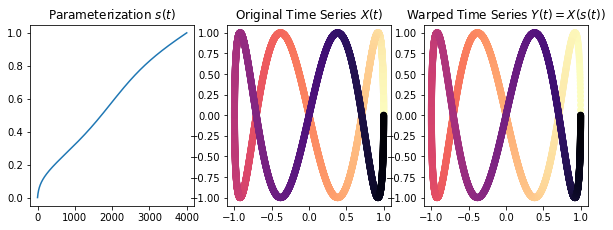

In [1]:
import linmdtw
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Step 1: Create the Lissajous curve
np.random.seed(1)
M = 5000
N = 4000
t1 = np.linspace(0, 1, M)
X = np.zeros((M, 2), dtype=np.float32)
X[:, 0] = np.cos(2*np.pi*t1)
X[:, 1] = np.sin(8*np.pi*t1)

## Step 2: Sample an element from a dictionary of parameterizations
## and use this parameterization to interpolate the original 
## time series
D = linmdtw.alignmenttools.get_parameterization_dict(N)
s = linmdtw.alignmenttools.sample_parameterization_dict(D, 4)
Y = linmdtw.alignmenttools.get_interpolated_euclidean_timeseries(X, s)

## Step 3: Plot the two time series to show the difference
plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.plot(s)
plt.title("Parameterization $s(t)$")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c = np.arange(M), cmap='magma_r')
plt.title("Original Time Series $X(t)$")
plt.subplot(133)
plt.scatter(Y[:, 0], Y[:, 1], c = np.arange(N), cmap='magma_r')
plt.title("Warped Time Series $Y(t) = X(s(t))$")

Now, we apply DTW to extract the warping path that aligns X to Y, and we compare this to the original parameterization

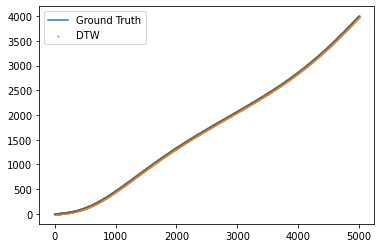

In [2]:
# Perform DTW using the divide and conquer scheme
cost_linmdtw, path_linmdtw = linmdtw.linmdtw(X, Y)
# Convert the ground truth parameterization to a warping path
path_orig = linmdtw.alignmenttools.param_to_warppath(s, M)
# Plot them on top of each other
plt.figure()
plt.plot(path_orig[:, 0], path_orig[:, 1])
plt.scatter(path_linmdtw[:, 0], path_linmdtw[:, 1], 1, c='C1')
plt.legend(["Ground Truth", "DTW"])
plt.show()

It appears that DTW is right on top of the original, but we can quantify this by looking at a distribution of shifts (as described in the paper) when compared to the ground truth path.  By this measure, we did quite well, as most of the shifts are zero, and the vast majority of the nonzero ones are 1, which is negligible compared to the number of samples

Text(0.5, 1.0, 'Histogram of shifts')

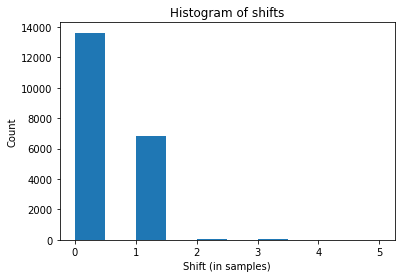

In [3]:
shifts = linmdtw.get_alignment_row_col_dists(path_linmdtw, path_orig)
plt.hist(shifts)
plt.xlabel("Shift (in samples)")
plt.ylabel("Count")
plt.title("Histogram of shifts")

## FastDTW And MrMsDTW

We can also compare the results to more approximate alignment schemes.  To show a different type of comparison, we will look at their costs.  In this example, fastdtw[1] uncovers an equal cost path to the optimal answer, while decreasing the amount of available memory (tau) in mrmsdtw [2] increases the error of the approximations.

[1] Salvador, Stan, and Philip Chan. "Toward accurate dynamic time warping in linear time and space." Intelligent Data Analysis 11.5 (2007): 561-580.

[2] Prätzlich, Thomas, Jonathan Driedger, and Meinard Müller. "Memory-restricted multiscale dynamic time warping." 2016 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2016.

In [4]:
cost_fastdtw, path_fastdtw = linmdtw.fastdtw(X, Y, radius=5)
cost_mrmsdtw7, path_mrmsdtw7 = linmdtw.mrmsdtw(X, Y, tau=10**7)
cost_mrmsdtw4, path_mrmsdtw4 = linmdtw.mrmsdtw(X, Y, tau=10**4)
print("Cost linmdtw = {:.3f}          ".format(cost_linmdtw))
print("Cost fastdtw = {:.3f}          ".format(cost_linmdtw))
print("Cost mrmsdtw, tau=10^7 = {:.3f}".format(cost_mrmsdtw7))
print("Cost mrmsdtw, tau=10^4 = {:.3f}".format(cost_mrmsdtw4))

Cost linmdtw = 7.277          
Cost fastdtw = 7.277          
Cost mrmsdtw, tau=10^7 = 11.860
Cost mrmsdtw, tau=10^4 = 42.648


## Constrained DTW (CDTW)

Finally, we provide an implementation of the classical "Sakoe-Chiba band" where a warping path is not allowed to deviate by more than a constant called the "radius," which we'll refer to as $r$.  In other words, $|i - j| \leq r$.  This is considered an approximation to a globally optimal solution to the DTW cost, but in some problems it is a useful constraint in its own right and can help with classification (see <a href = "https://www.cs.unm.edu/~mueen/DTW.pdf">slides here</a> by Keogh and Mueen).  To boot, it is substantially faster, bringing the naive implementation from $O(N^2)$ to $O(Nr)$, and usually $r \ll N$.

We'll resample the curves with a coarser sampling in the example below to make it easier to see the differences with different radii.

Text(0.5, 1.0, 'Warped Time Series $Y(t) = X(s(t))$')

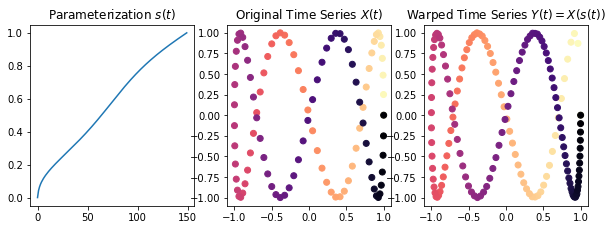

In [5]:
np.random.seed(1)
M = 100
N = 150
t1 = np.linspace(0, 1, M)
X = np.zeros((M, 2), dtype=np.float32)
X[:, 0] = np.cos(2*np.pi*t1)
X[:, 1] = np.sin(8*np.pi*t1)

## Step 2: Sample an element from a dictionary of parameterizations
## and use this parameterization to interpolate the original
## time series
D = linmdtw.alignmenttools.get_parameterization_dict(N)
s = linmdtw.alignmenttools.sample_parameterization_dict(D, 4)
Y = linmdtw.alignmenttools.get_interpolated_euclidean_timeseries(X, s)

## Step 3: Plot the two time series to show the difference
plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.plot(s)
plt.title("Parameterization $s(t)$")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c = np.arange(M), cmap='magma_r')
plt.title("Original Time Series $X(t)$")
plt.subplot(133)
plt.scatter(Y[:, 0], Y[:, 1], c = np.arange(N), cmap='magma_r')
plt.title("Warped Time Series $Y(t) = X(s(t))$")

Now, we will perform cdtw with a radius of 10.  The warping path matches nearly exactly with the ground parameterization

Cost = 7.435


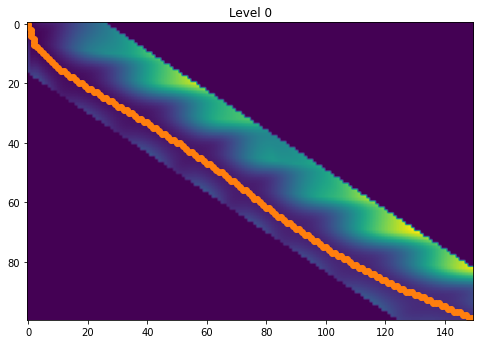

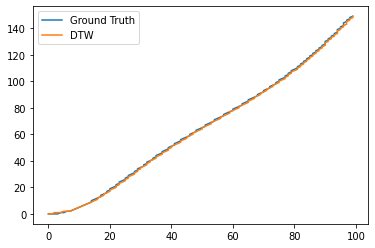

In [6]:
# Setting do_plot to True will plot the path on the cost matrix
cost_cdtw, path_cdtw = linmdtw.cdtw(X, Y, 10, do_plot=True) 
print("Cost = {:.3f}".format(cost_cdtw))
# Convert the ground truth parameterization to a warping path
path_orig = linmdtw.alignmenttools.param_to_warppath(s, M)
# Plot them on top of each other
plt.figure()
plt.plot(path_orig[:, 0], path_orig[:, 1])
plt.plot(path_cdtw[:, 0], path_cdtw[:, 1], 1, c='C1')
plt.legend(["Ground Truth", "DTW"])
plt.show()

Now let's decrease the radius to 4.  Though the solution is still reasonable, the path no longer has the freedom to warp as much as is needed in this particular example, and the cost goes up

Cost = 28.643


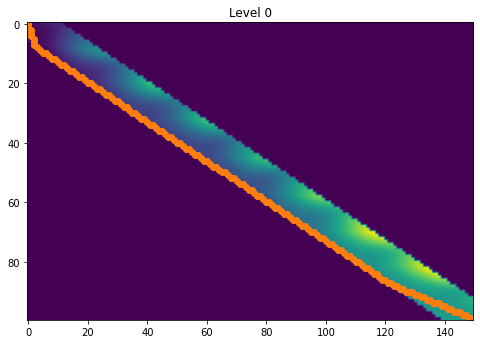

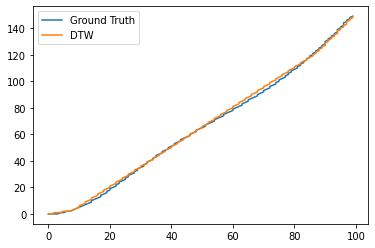

In [7]:
cost_cdtw, path_cdtw = linmdtw.cdtw(X, Y, 4, do_plot=True)
print("Cost = {:.3f}".format(linmdtw.get_path_cost(X, Y, path_cdtw)))
# Convert the ground truth parameterization to a warping path
path_orig = linmdtw.alignmenttools.param_to_warppath(s, M)
# Plot them on top of each other
plt.figure()
plt.plot(path_orig[:, 0], path_orig[:, 1])
plt.plot(path_cdtw[:, 0], path_cdtw[:, 1], 1, c='C1')
plt.legend(["Ground Truth", "DTW"])
plt.show()